# Day 1 - Points


Data sources:
- Shapefile from Natural Earth ([download here](https://www.naturalearthdata.com/downloads/))
- Data on renewables from Renewable Energy Planning Database available [here](https://www.gov.uk/government/publications/renewable-energy-planning-database-monthly-extract)


## Setup

In [1]:
import os
import configparser

import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Point, Polygon

import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import seaborn as sns

import matplotlib.colors as colors
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from matplotlib.lines import Line2D

['#2A186C', '#252DA3', '#0C5493', '#206E8B', '#348688', '#43A084', '#5AB978', '#86D062', '#CADF69', '#FDEF9A']


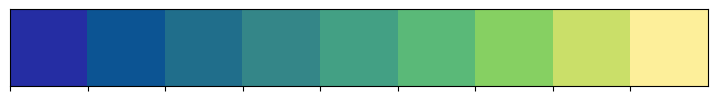

In [2]:
# import colors
import matplotlib.colors as colors
from palettable.cmocean.sequential import Haline_10
print(Haline_10.hex_colors)
sns.palplot(Haline_10.hex_colors[1:])

In [3]:
# set custom fonts
plt.rcParams['font.family'] = ['Inter']
from matplotlib import font_manager
subtitle_font = font_manager.FontProperties(fname='C:\\Windows\\Fonts\\Inconsolata-Medium.ttf')
title_font = font_manager.FontProperties(fname='C:\\Windows\\Fonts\\Inconsolata-Semibold.ttf')

In [4]:
#set filepaths
project_root = os.path.abspath(os.getcwd())
root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
config_file =  os.path.join(root, 'config.cfg')

# geodata for shapefiles
config = configparser.ConfigParser()
config.read(config_file)
gdata_root = config['geodata']['path']

## Load data

In [5]:
# Load map of UK
world = gpd.GeoDataFrame.from_file(os.path.join(gdata_root, 'natural-earth\\ne_50m_admin_0_countries\\ne_50m_admin_0_countries.shp'))
uk = world[world['ADM0_A3']=='GBR'].to_crs('27700')

In [6]:
# load renewables data set
df = pd.read_excel('repd-july-2023.xlsx', sheet_name='REPD Publication')
geometry = [Point(xy) for xy in zip(df['X-coordinate'].astype(float), df['Y-coordinate'].astype(float))]
gdf = gpd.GeoDataFrame(df, crs = '27700', geometry = geometry)

In [7]:
# extract year it became operational
gdf['OperationalYear'] = gdf['Operational'].astype(str).str.strip().str[0:4]
gdf['OperationalYear'] = gdf['OperationalYear'].replace('nan', 'None').replace('', 'None')
gdf['OperationalYear'] = [int(i) if i != 'None' else np.nan for i in  gdf['OperationalYear']]

# Visualise

In [8]:
# filter data
technology = ['Solar Photovoltaics', 'Wind Onshore']
data = gdf[(gdf['Development Status (short)']=='Operational') & (gdf['Technology Type'].isin(technology))]
data.loc[:,'Technology Type'] = data.loc[:,'Technology Type'].str.replace('Solar Photovoltaics', 'Solar').str.replace( 'Wind Onshore', 'Wind')

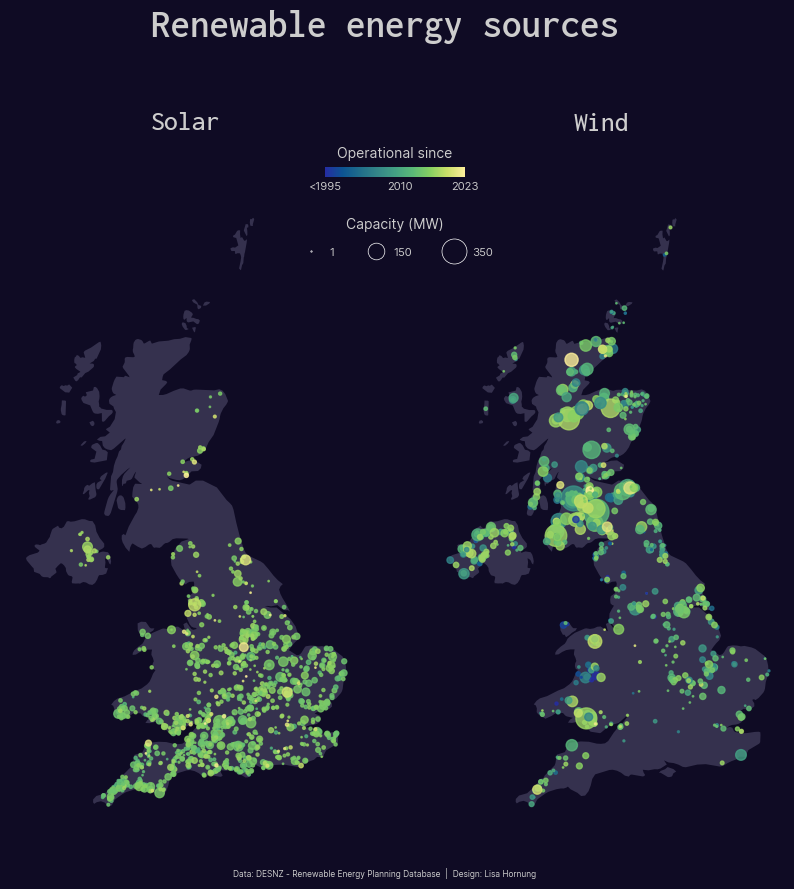

In [15]:
# set colors -----------
cmap = colors.LinearSegmentedColormap.from_list('cmap',[colors.hex2color(c) for c in  Haline_10.hex_colors[1:]])
base = '#35314E'
bg = '#0F0B24'
text = '#CDCDCD'

# layout ------------------
layout = [['Solar','Wind']]
fig,axs = plt.subplot_mosaic(layout, figsize=(10,10), empty_sentinel='___') 
fig.set_facecolor(bg)

# plot data ---------------
for ax in axs:
    data_filtered= data[data['Technology Type']==ax].dropna(subset='Installed Capacity (MWelec)')
    data_filtered['Installed Capacity (MWelec)']=data_filtered['Installed Capacity (MWelec)'].astype(int)
    data_filtered.plot(column='OperationalYear', ax=axs[ax], cmap=cmap, s=data_filtered['Installed Capacity (MWelec)'],
                        vmin=1995,vmax=2023, zorder=3, alpha=0.8)
    uk.plot(ax=axs[ax], color=base, zorder=1)
    
    # add title
    trans = transforms.blended_transform_factory(axs[ax].transAxes, axs[ax].transAxes)
    axs[ax].text(0.4, 1.1, ax, va='center', transform=trans, color=text, fontsize=20, fontproperties=subtitle_font)

    axs[ax].axis('off')

# legends -----------------------
# colorbar
lgd = fig.add_axes([0.44, 0.83, 0.14, 0.01])
cmappable = ScalarMappable(norm=Normalize(1995,2023), cmap=cmap)              
cb = plt.colorbar(cmappable, cax=lgd, anchor=(1,1.2), orientation='horizontal', drawedges=False, ticks=[1995,2010, 2023])
cb.set_ticklabels(['<1995','2010', '2023'])
lgd.tick_params(colors=text,length=0, labelsize=8)
cb.outline.set_visible(False)
trans = transforms.blended_transform_factory(lgd.transAxes, lgd.transAxes)
lgd.text(0.5, 1.9, 'Operational since', ha='center', size=10, linespacing=1.5, color=text, transform=trans)

# bubbles
lgd2 = fig.add_axes([0.46, 0.75, 0.10, 0.01]) 
legend_elements = [Line2D([0], [0], marker='o', markeredgecolor='white',markersize=1, color='None', markeredgewidth=0.5, label='1'),
                    Line2D([0], [0], marker='o', markeredgecolor='white',markersize=12, color='None', markeredgewidth=0.5, label='150'),
                    Line2D([0], [0], marker='o', markeredgecolor='white',markersize=18, color='None', markeredgewidth=0.5, label='350')]
L = lgd2.legend(frameon=False, handles=legend_elements, loc='center', ncol=3, handletextpad=0.3,labelspacing=-5)
plt.setp(L.texts,  va='baseline', size=8, color=text )  
trans = transforms.blended_transform_factory(lgd2.transAxes, lgd2.transAxes)  
lgd2.text(0.5, 2.8, 'Capacity (MW)', ha='center', size=10, linespacing=1.5, color=text, transform=trans)
lgd2.axis('off')

# title + footer -----------------
plt.figtext(0.5, 0.97 , 'Renewable energy sources', fontsize=28, ha='center', color=text, fontproperties=title_font)
plt.figtext(0.5, 0.13 , 'Data: DESNZ - Renewable Energy Planning Database  |  Design: Lisa Hornung', fontsize=6, fontweight='regular', ha='center', color=text)

#export
plt.savefig('renewables-uk.png', facecolor=bg, dpi=120, bbox_inches='tight',pad_inches=1)

plt.show()